In [1]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd LightGBM
!mkdir build
%cd build
!cmake ../../LightGBM -DUSE_GPU=1
!make -j4
%cd ../python-package
!python3 setup.py install --gpu

Cloning into 'LightGBM'...
remote: Enumerating objects: 25583, done.
remote: Counting objects: 100% (25583/25583), done.
remote: Compressing objects: 100% (6067/6067), done.
remote: Total 25583 (delta 18993), reused 24969 (delta 18640), pack-reused 0
Receiving objects: 100% (25583/25583), 18.53 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (18993/18993), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
rem

In [2]:
cd ../..

/content


In [3]:
!pip install kaggle --upgrade
# !pip install lightgbm
# !pip install lightgbm --install-option=--gpu
!pip install optuna

     |████████████████████████████████| 308 kB 9.5 MB/s 
     |████████████████████████████████| 210 kB 76.6 MB/s 
     |████████████████████████████████| 81 kB 12.8 MB/s 
     |████████████████████████████████| 78 kB 9.6 MB/s 
     |████████████████████████████████| 113 kB 82.9 MB/s 
     |████████████████████████████████| 150 kB 80.3 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5d6e1d3115b3d623b4d5b1c557bbcf4143df33e993343dbe61999052ab71739c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [5]:
!kaggle competitions download -c spaceship-titanic

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 96.5MB/s]


In [6]:
!unzip spaceship-titanic.zip

Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import numpy as np
import pandas as pd

Load datasets

In [8]:
basepath = "/content/"
df_train = pd.read_csv(basepath + "train.csv")
df_test = pd.read_csv(basepath + "test.csv")

In [9]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# EDA and Feature Engineering

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [11]:
df_train.describe().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [12]:
df_train.shape

(8693, 14)

In [13]:
import seaborn as sns

In [14]:
# Separate numerical and categorical features
num_vars = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cat_vars = [col for col in df_train.columns if col not in num_vars and col != 'Transported']

## Categorical features

In [15]:
# Check unique values for each categorical feature
df_train[cat_vars].nunique() 

PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64

From above we can see 'PassengerId', 'Cabin'. 'Name' these three columns contain thousands of unique values within each feature.

The simplist way is dropping all of them. However, from the description of the data we know there are patterns inside 'PassengerId' and 'Cabin' and we can try to extract useful information from these two columns.

*   PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

*   Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

From the definition above, **we can try to classify 'PassengerId' into groups by the first 'gggg' and 'Cabin' into 'deck', 'number' and 'side' three parts.**

'Name' column to be dropped as it does not provide more info other than name.



In [16]:
# Extract group info from 'PassengerId' and then drop 'PassengerId'
def group_extract(df):
  df['Group'] = df['PassengerId'].str[:4].astype('int') # Turn to integer type because format 'gggg' are four digit numbers
  return df

df_train = group_extract(df_train)
df_train = df_train.drop('PassengerId', axis=1)
df_test = group_extract(df_test)

In [17]:
# Extract deck/number/port from 'Cabin' and drop 'Cabin'
def dnp_extract(df):
  df['Deck'] = df['Cabin'].str[0]
  df['Deck_num'] = df['Cabin'].str[2].astype('float') # Here use float type as there are NaNs in 'Cabin' column
  df['Port'] = df['Cabin'].str[-1]
  df = df.drop('Cabin', axis=1)
  return df

df_train = dnp_extract(df_train)
df_test = dnp_extract(df_test)

In [18]:
# Drop 'Name' column
df_train = df_train.drop('Name', axis=1)
df_test = df_test.drop('Name', axis=1)

In [19]:
# Update categorical/numerical features
cat_vars = [i for i in cat_vars if i not in ['PassengerId', 'Cabin', 'Name']]

for i in ['Deck', 'Port']:
  cat_vars.append(i)

for i in ['Group', 'Deck_num']:
  num_vars.append(i)

In [20]:
cat_vars

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Port']

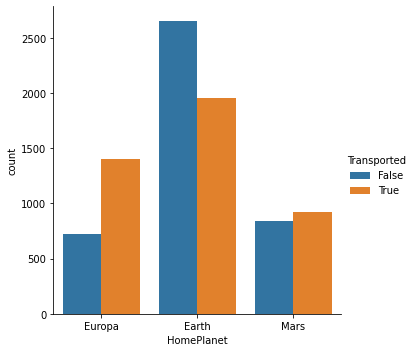

In [21]:
# HomePlanet --> Transported relationship
sns.catplot(x='HomePlanet', hue='Transported', kind='count', data=df_train) # Passengers from Europa are more likely transported

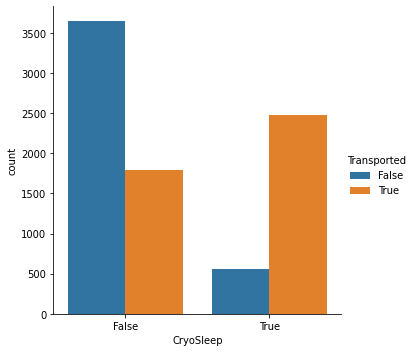

In [22]:
# CryoSleep --> Transported
sns.catplot(x='CryoSleep', hue='Transported', kind='count', data=df_train) # Plot shows passengers who were in cryosleep had higher probability of being transported.

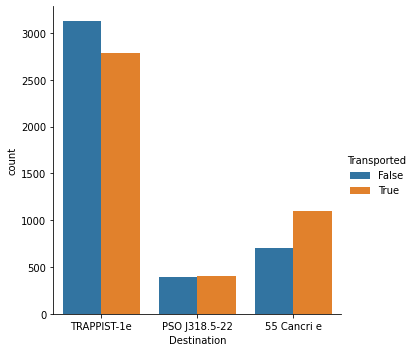

In [23]:
# Destination --> Transported
sns.catplot(x='Destination', hue='Transported', kind='count', data=df_train) # No obvious trend

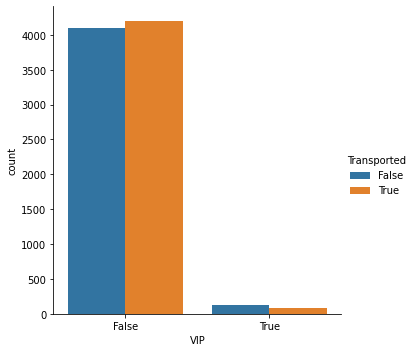

In [24]:
# VIP --> Transported
sns.catplot(x='VIP', hue='Transported', kind='count', data=df_train) # No obvious trend

## Numerical features

The data description says "RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities." which indicates that 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa' and 'VRDeck' all belong to the amenities expense. Therefore, sum them up and create a new column 'Amenities' might be a good idea.

In [25]:
num_vars

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Group',
 'Deck_num']

In [26]:
# Create 'Amenities' by summing up 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' columns
df_train['Amenities'] = df_train['RoomService'] + df_train['FoodCourt'] + df_train['ShoppingMall'] + df_train['Spa'] + df_train['VRDeck']
df_test['Amenities'] = df_test['RoomService'] + df_test['FoodCourt'] + df_test['ShoppingMall'] + df_test['Spa'] + df_test['VRDeck']

In [27]:
# Update numerical features
num_vars.append('Amenities')

In [28]:
import matplotlib.pyplot as plt

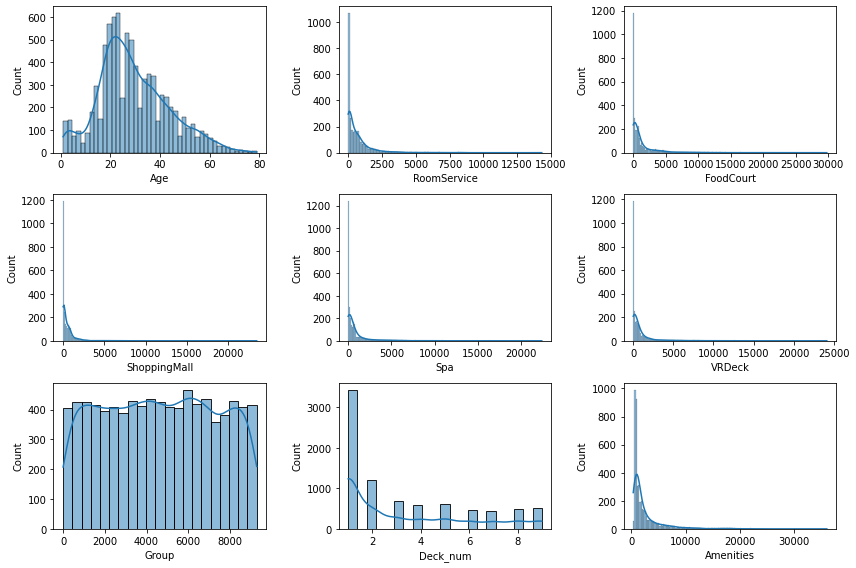

In [29]:
# Check numerical features' distributions
fig, ax = plt.subplots(3, 3, figsize=(12,8))

for ax, feature in zip(ax.ravel(), num_vars):
  sns.histplot(x=df_train[feature][df_train[feature] != 0], ax=ax, kde=True) # value 0 dropped as it's volume would affect the plot

fig.tight_layout()

We notice that there might be outliers existing in 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck' and 'Amenities'.

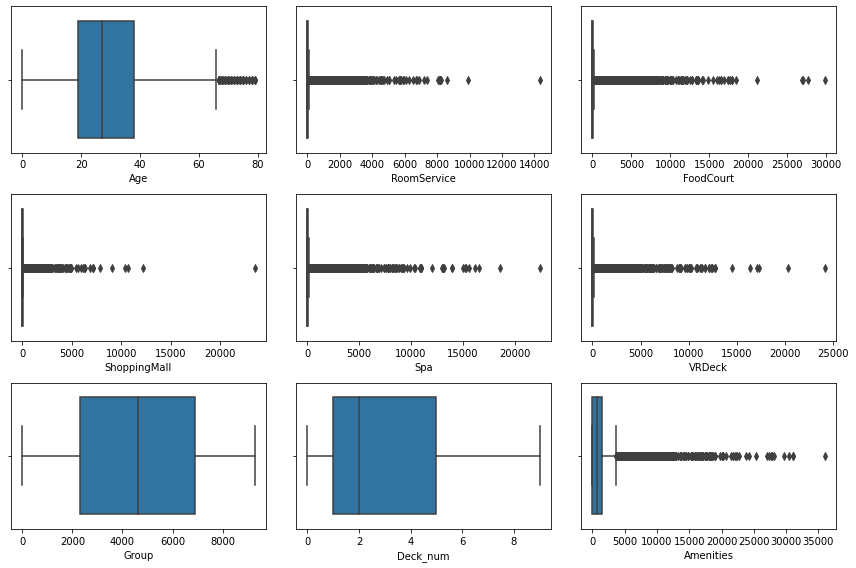

In [30]:
# Check outliers
fig, ax = plt.subplots(3, 3, figsize=(12,8))

for ax, feature in zip(ax.ravel(), num_vars):
  sns.boxplot(x=df_train[feature], ax=ax) 

fig.tight_layout()

In [31]:
# Handle outliers
def outlier_handle(col, boundary):
  df_train.loc[df_train[col] > boundary, col] = df_train.loc[df_train[col] <= boundary, col].mean()
  df_test.loc[df_train[col] > boundary, col] = df_train.loc[df_train[col] <= boundary, col].mean()

outlier_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Amenities']
boundaries = [8000, 20000, 10000, 18000, 14000, 35000]

for col, boundary in zip(outlier_cols, boundaries):
  outlier_handle(col, boundary)

## Others

In [32]:
# Check target distribution
df_train.Transported.value_counts() # Nearly 50-50 which indicates no obvious imbalance

True     4378
False    4315
Name: Transported, dtype: int64

In [33]:
# Check duplicated rows
df_train.duplicated().any()

True

In [34]:
# Drop duplicates
df_train = df_train.drop_duplicates()

In [35]:
# Check missing values
df_train.isna().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Group             0
Deck            199
Deck_num        199
Port            199
Amenities       908
dtype: int64

# Data pre-processing

In [36]:
num_vars.remove('Deck_num')
cat_vars.append('Deck_num')

In [37]:
# Impute missing values
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

df_train[num_vars] = num_imputer.fit_transform(df_train[num_vars])
df_train[cat_vars] = cat_imputer.fit_transform(df_train[cat_vars])

df_test[num_vars] = num_imputer.transform(df_test[num_vars])
df_test[cat_vars] = cat_imputer.transform(df_test[cat_vars])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [38]:
# Encode categorical variables
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_data = encoder.fit_transform(df_train[cat_vars])
ohe_data_test = encoder.transform(df_test[cat_vars])

ohe_colnames = encoder.get_feature_names(cat_vars)

df_train = pd.concat([df_train.drop(cat_vars, axis=1), pd.DataFrame(ohe_data, columns=ohe_colnames, index=df_train.index)], axis=1)
df_test = pd.concat([df_test.drop(cat_vars, axis=1), pd.DataFrame(ohe_data_test, columns=ohe_colnames, index=df_test.index)], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
df_train['Transported'].replace({True: 1, False: 0}, inplace=True)

## Check correlations among features

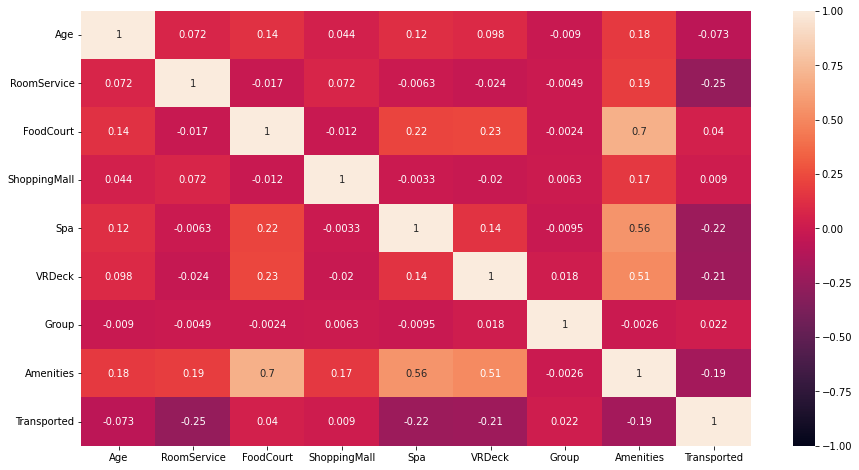

In [40]:
plt.figure(figsize=(15, 8))
num_cols = num_vars.copy()
num_cols.append('Transported')
sns.heatmap(df_train[num_cols].corr(), annot=True, vmin=-1, vmax=1)

As shown above, we can see that 'ShoppingMall', 'FoodCourt' and 'Group' have relatively low correlations to the target and 'ShoppingMall' has a hight correlation to 'Amenities'. Therefore, drop 'ShoppingMall', 'FoodCourt' and 'Group'.

In [41]:
df_train = df_train.drop(['ShoppingMall', 'FoodCourt', 'Group'], axis=1)
df_test = df_test.drop(['ShoppingMall', 'FoodCourt', 'Group'], axis=1)

## Split train/test dataset

In [42]:
# Create train, validation datasets
from sklearn.model_selection import train_test_split
X = df_train.drop('Transported', axis=1).copy()
y = df_train['Transported'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Modeling

### Light Gredient Boosted Machine(LGBMClassifier)

In [43]:
!pip install lightgbm

In [44]:
import lightgbm as lgb

In [64]:
# Baseline
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3093, number of negative: 2985
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 6078, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508885 -> initscore=0.035542
[LightGBM] [Info] Start training from score 0.035542
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1330
           1       0.80      0.82      0.81      1276

    accuracy                           0.81      2606
   macro avg       0.81      0.81      0.81      2606
weighted avg       0.81      0.81      0.81      2606

0.8108211818879509


In [193]:
# Hyperparameter tuning using optuna
import optuna
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback


def objective(trial, X, y):
    param_grid = {
        "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 25000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 10000, step=100),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 100, step=5),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 100, step=5),
        "min_split_gain": trial.suggest_float("min_split_gain", 0, 50),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 1, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.1, 1, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgb.LGBMClassifier(objective="binary", verbosity=-1,  **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            # early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss"),
                lgb.early_stopping(100)
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [66]:
optuna.logging.set_verbosity(0)
import warnings
warnings.filterwarnings("ignore")

In [216]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=300)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693127
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.693127
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.693127
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.693127
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.693131
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.565656
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.557466
Training until validation scores don't impr

In [217]:
study.best_value

0.4124018891776853

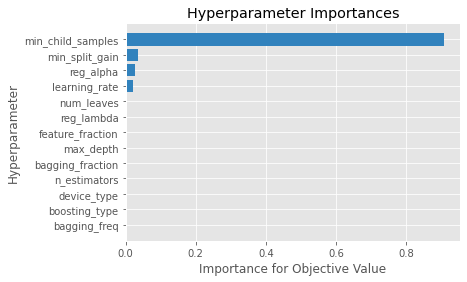

In [218]:
# Check feature importance
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

best_params = study.best_params
gbm = lgb.LGBMClassifier(objective="binary", verbosity=-1, **best_params)
gbm.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=1, device_type='gpu',
               feature_fraction=0.5, learning_rate=0.190959551970909,
               max_depth=10, min_split_gain=0.01640320685863221,
               n_estimators=10000, num_leaves=5580, objective='binary',
               reg_alpha=5, reg_lambda=5, verbosity=-1)

In [220]:
y_pred = gbm.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1261
           1       0.81      0.80      0.80      1345

    accuracy                           0.80      2606
   macro avg       0.80      0.80      0.80      2606
weighted avg       0.80      0.80      0.80      2606

0.7996930161166539


## Make predictions and produce submit file

In [ ]:
df_test

,PassengerId,Age,RoomService,Spa,VRDeck,Amenities,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,...,Deck_num_0.0,Deck_num_1.0,Deck_num_2.0,Deck_num_3.0,Deck_num_4.0,Deck_num_5.0,Deck_num_6.0,Deck_num_7.0,Deck_num_8.0,Deck_num_9.0
0,0013_01,27.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0018_01,19.000000,0.0,2823.0,0.0,2832.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0019_01,31.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0021_01,38.000000,0.0,181.0,585.0,7418.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0023_01,20.000000,10.0,0.0,0.0,645.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,34.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4273,9269_01,42.000000,0.0,10.0,144.0,1018.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4274,9271_01,28.843739,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4275,9273_01,28.843739,0.0,0.0,523.0,3203.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# Drop useless columns
idx = df_test['PassengerId']
df_test = df_test.drop('PassengerId', axis=1)

In [100]:
def submit(model):
  y_test = model.predict(df_test)
  y_test = pd.Series(y_test, name='Transported')
  y_test = y_test.astype('bool')
  df_submit = pd.concat([idx, y_test], axis=1)
  df_submit.to_csv('/content/submission.csv', index=False)

  !kaggle competitions submit -c spaceship-titanic -f submission.csv -m "Message"
  
  return

In [221]:
submit(gbm)

100% 56.4k/56.4k [00:02<00:00, 20.4kB/s]
Successfully submitted to Spaceship Titanic